# Map of all facilities with violations

### (by year and contaminant type)

In [1]:
# USA map with facilities having violations
# Assumes you have SWDIS.zip data locally!

import os
import numpy as np
import pandas as pd
# Installation: https://altair-viz.github.io/getting_started/installation.html#installation-notebook
import altair as alt
import zipfile
from vega_datasets import data

DATA_DIR = '../../../../data'

SDWIS_DIR = os.path.join(DATA_DIR, 'sdwis')
EPA_DIR = os.path.join(DATA_DIR, 'epa')
GEO_DIR = os.path.join(DATA_DIR, 'geography')

In [2]:
water_sys = pd.read_csv(os.path.join(SDWIS_DIR, 'WATER_SYSTEM.csv'),
                        sep=',',
                        dtype={'WATER_SYSTEM.ZIP_CODE': np.str},
                        low_memory=False)

viol = pd.read_csv(os.path.join(SDWIS_DIR, 'VIOLATION.csv'),
                   sep=',',
                   dtype={'VIOLATION.CONTAMINANT_CODE': np.str},
                   low_memory=False)

drinking_water_regs = pd.read_csv(os.path.join(EPA_DIR, 'drinking-water-regulations.csv'),
                                  sep=',',
                                  dtype={'SDWIS_CONTAMINANT_CODE': np.str}, 
                                  low_memory=False)

# water_sys_fac = pd.read_csv(os.path.join(SDWIS_DIR, 'WATER_SYSTEM_FACILITY.csv'), sep=',')
# enfo_act = pd.read_csv(os.path.join(SDWIS_DIR, 'ENFORCEMENT_ACTION.csv'), sep=',')
# geog_area = pd.read_csv(os.path.join(SDWIS_DIR, 'GEOGRAPHIC_AREA.csv'), sep=',')
# lcr_sample = pd.read_csv(os.path.join(SDWIS_DIR, 'LCR_SAMPLE.csv'), sep=',')
# lcr_sample_res = pd.read_csv(os.path.join(SDWIS_DIR, 'LCR_SAMPLE_RESULT.csv'), sep=',')
# serv_area = pd.read_csv(os.path.join(SDWIS_DIR, 'SERVICE_AREA.csv'), sep=',')
# treat = pd.read_csv(os.path.join(SDWIS_DIR, 'TREATMENT.csv'), sep=',')
# viol = pd.read_csv(os.path.join(SDWIS_DIR, 'VIOLATION.csv'), sep=',')
# viol_enf_assoc = pd.read_csv(os.path.join(SDWIS_DIR, 'VIOLATION_ENF_ASSOC.csv'), sep=',')

In [3]:
# Label data with full year, e.g., 2012 for 01-JUL-12
def get_year_from_mmddyy_series(ser, last_year_in_2000s=pd.Timestamp('now').year):
    """
    Expected input will be in the form 01-JUL-12.
    Output will be the year of the data.
    Assumes years will never be greater than current year.
    """
                                
    last_two_digits_year_cutoff = int(str(last_year_in_2000s)[-2:])
    
    # calculate last two digits of year
    return_series = ser.str.split('-').str[2].astype(int)
    
    # add first two digits
    return_series += (
        + (2000*(return_series <= last_two_digits_year_cutoff))
        + (1900*(return_series > last_two_digits_year_cutoff))
    )
    
    return return_series

In [4]:
viol = viol[['VIOLATION.PWSID', 'VIOLATION.FACILITY_ID', 'VIOLATION.CONTAMINANT_CODE', \
             'VIOLATION.COMPL_PER_BEGIN_DATE']]

viol['VIOLATION.YEAR'] = get_year_from_mmddyy_series(viol['VIOLATION.COMPL_PER_BEGIN_DATE'])

In [5]:
water_sys = water_sys[['WATER_SYSTEM.PWSID', 'WATER_SYSTEM.ZIP_CODE']].drop_duplicates()

In [6]:
# Get latitude, longitude from Vega zipcodes data set
# Fetched from Vega data set: https://raw.githubusercontent.com/vega/vega-datasets/master/data/zipcodes.csv
# source = data.zipcodes.url
# zip_code,latitude,longitude,city,state,county
# 00501,40.922326,-72.637078,Holtsville,NY,Suffolk
# 45430,39.709159,-84.104836,Dayton,OH,Montgomery
zipcodes = pd.read_csv(os.path.join(GEO_DIR, 'zipcodes.csv'),
                       sep=',',
                       dtype={'zip_code': np.str})

water_sys = pd.merge(water_sys, zipcodes, left_on='WATER_SYSTEM.ZIP_CODE', right_on='zip_code')
water_sys_viol = pd.merge(water_sys, viol, left_on='WATER_SYSTEM.PWSID', right_on='VIOLATION.PWSID')


water_sys_viol_contaminants = pd.merge(water_sys_viol, drinking_water_regs, \
                                      left_on='VIOLATION.CONTAMINANT_CODE', right_on='SDWIS_CONTAMINANT_CODE')
water_sys_viol_contaminants.head()

,WATER_SYSTEM.PWSID,WATER_SYSTEM.ZIP_CODE,zip_code,latitude,longitude,city,state,county,VIOLATION.PWSID,VIOLATION.FACILITY_ID,VIOLATION.CONTAMINANT_CODE,VIOLATION.COMPL_PER_BEGIN_DATE,VIOLATION.YEAR,CONTAMINANT,SDWIS_CONTAMINANT_CODE,TYPE,MCL_GOAL,MCL_OR_TT,POTENTIAL_HEALTH_EFFECTS,SOURCES_OF_CONTAMINANT_IN_DRINKING_WATER
0,CA3601100,92365,92365,34.90534,-115.932613,Newberry Springs,CA,San Bernardino,CA3601100,NaN,3100,01-APR-10,2010,Total Coliforms (including fecal coliform and ...,3100,Microorganisms,zero,5.0%4,Not a health threat in itself; it is used to i...,Coliforms are naturally present in the environ...
1,CA3601100,92365,92365,34.90534,-115.932613,Newberry Springs,CA,San Bernardino,CA3601100,NaN,3100,01-APR-08,2008,Total Coliforms (including fecal coliform and ...,3100,Microorganisms,zero,5.0%4,Not a health threat in itself; it is used to i...,Coliforms are naturally present in the environ...
2,CA3601151,92365,92365,34.90534,-115.932613,Newberry Springs,CA,San Bernardino,CA3601151,NaN,3100,01-AUG-12,2012,Total Coliforms (including fecal coliform and ...,3100,Microorganisms,zero,5.0%4,Not a health threat in itself; it is used to i...,Coliforms are naturally present in the environ...
3,CA3601015,92365,92365,34.90534,-115.932613,Newberry Springs,CA,San Bernardino,CA3601015,NaN,3100,01-AUG-12,2012,Total Coliforms (including fecal coliform and ...,3100,Microorganisms,zero,5.0%4,Not a health threat in itself; it is used to i...,Coliforms are naturally present in the environ...
4,CA3600407,92365,92365,34.90534,-115.932613,Newberry Springs,CA,San Bernardino,CA3600407,NaN,3100,01-APR-96,1996,Total Coliforms (including fecal coliform and ...,3100,Microorganisms,zero,5.0%4,Not a health threat in itself; it is used to i...,Coliforms are naturally present in the environ...


In [7]:
drinking_water_regs['TYPE'].drop_duplicates()

0              Microorganisms
10    Disinfection Byproducts
14              Disinfectants
17        Inorganic Chemicals
33          Organic Chemicals
86              Radionuclides
Name: TYPE, dtype: object

In [8]:
# Filter data to display by reported year and contaminant type; 
# this can be modified as needed to filter by different parameters
def get_source_data_frame(df, year=None, contaminant_types=[]):
    if year:
        df = df.loc[df['VIOLATION.YEAR'] == year, :]
    if contaminant_types:
         df = df.loc[df['TYPE'].isin(contaminant_types), :]
    return df[['zip_code', 'latitude', 'longitude']].drop_duplicates()

In [9]:
# zip_code,latitude,longitude,city,state,county
# 00501,40.922326,-72.637078,Holtsville,NY,Suffolk
# 00544,40.922326,-72.637078,Holtsville,NY,Suffolk
# 02101,42.370567,-71.026964,Boston,MA,Suffolk
# 45430,39.709159,-84.104836,Dayton,OH,Montgomery

# source = pd.DataFrame({'zip_code': ['00501', '02101', '45430'],
#                        'latitude': [40.922326, 42.370567, 39.709159],
#                        'longitude': [-72.637078, -71.026964, -84.104836]})

# configure chart to be rendered in notebook
alt.renderers.enable('notebook')

# avoid data size MaxRowsError 
alt.data_transformers.enable('json')

def draw_map(source, title):
    return alt.Chart(source).transform_calculate(
        "leading digit", alt.expr.substring(alt.datum.zip_code, 0, 1)
    ).mark_circle(size=3).encode(
        longitude='longitude:Q',
        latitude='latitude:Q',
        color='leading digit:N',
        tooltip='zip_code:N'
    ).project(
        type='albersUsa'
    ).properties(
        width=325,
        height=200,
        title=str(title)
    )


# Geographic Visualizations

In [10]:
# Filter map based on what contaminants you want
contaminant_types = ['Organic Chemicals']

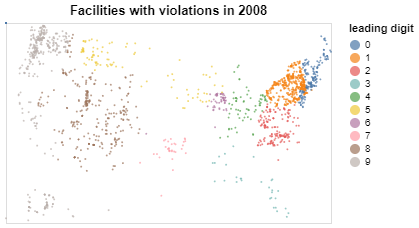

In [11]:
# Display facilities with violations for year and contaminant type

year = 2008

draw_map(get_source_data_frame(water_sys_viol_contaminants,
                               year=year,
                               contaminant_types=contaminant_types),
         title=f'Facilities with violations in {year}')

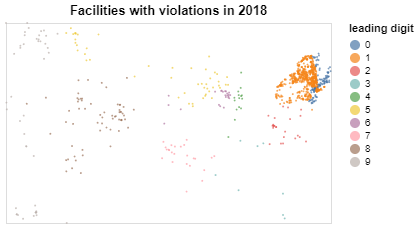

In [12]:
year = 2018

draw_map(get_source_data_frame(water_sys_viol_contaminants,
                               year=year,
                               contaminant_types=contaminant_types),
         title=f'Facilities with violations in {year}')